In [ ]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt
import timeit
import load_cifar as data_helper

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

<h1>Load training, validation, testing set from your preprocessed files</h1>

In [ ]:
train = data_helper.unpickle('catdog_train_data.p')
test = data_helper.unpickle('catdog_test_data.p')
valid = data_helper.unpickle('catdog_valid_data.p')

In [ ]:
x_train = train[0]
y_train = train[1]

x_test = test[0]
y_test = test[1]

x_valid = valid[0]
y_valid = valid[1]

print(x_train.shape)
print(y_train.shape)

<h1>Define hyperparameter</h1>

In [ ]:
epochs = 10
lr = 0.01
batch_size = 128
dr=0.5

<h1>Placeholder</h1>

In [ ]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, 227, 227,3], name='x')
y = tf.placeholder(tf.float32, shape=[None, 2], name='y')


W = {
    "Wc1": tf.Variable(tf.truncated_normal([11,11,3,96], mean=0, stddev=0.01), name='Wc1'),
    "Wc2": tf.Variable(tf.truncated_normal([5,5,96,256], mean=0, stddev=0.01), name='Wc2'),
    "Wc3": tf.Variable(tf.truncated_normal([3,3,256,384], mean=0, stddev=0.01), name='Wc3'),
    "Wc4": tf.Variable(tf.truncated_normal([3,3,384,384], mean=0, stddev=0.01), name='Wc4'),
    "Wc5": tf.Variable(tf.truncated_normal([3,3,384,256], mean=0, stddev=0.01), name='Wc5'),
    "Wf1": tf.Variable(tf.truncated_normal([6*6*256, 4096], mean=0, stddev=0.01), name='Wf1'),
    "Wf2": tf.Variable(tf.truncated_normal([4096, 4096], mean=0, stddev=0.01), name='Wf2'),
    "Wf3": tf.Variable(tf.truncated_normal([4096, 2], mean=0, stddev=0.01), name='Wf3')
}

b = {
    "bc1": tf.Variable(tf.constant(0.0, shape=[96]), name="bc1"),
    "bc2": tf.Variable(tf.constant(1.0, shape=[256]), name="bc2"),
    "bc3": tf.Variable(tf.constant(0.0, shape=[384]), name="bc3"),
    "bc4": tf.Variable(tf.constant(1.0, shape=[384]), name="bc4"),
    "bc5": tf.Variable(tf.constant(1.0, shape=[256]), name="bc5"),
    "bf1": tf.Variable(tf.constant(1.0, shape=[4096]), name="bf1"),
    "bf2": tf.Variable(tf.constant(1.0, shape=[4096]), name="bf2"),
    "bf3": tf.Variable(tf.constant(1.0, shape=[2]), name="bf3")
}

<h1>AlexNet</h1>

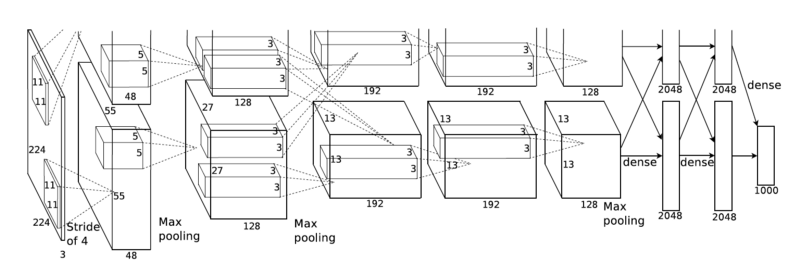

In [24]:
from IPython.display import Image
Image("alexnet.png")

In [ ]:
def alexnet(x):
    
    ### Convoltuional layer 1 ###
    c1 = tf.nn.conv2d(x, W['Wc1'], strides=[1,4,4,1], padding='SAME', name='c1')
    c1 = tf.nn.bias_add(c1, b['bc1'])
    c1 = tf.nn.relu(c1)
    c1 = tf.nn.local_response_normalization(c1, depth_radius=5.0, bias=2.0, alpha=1e-4, beta=0.75)
    c1 = tf.nn.max_pool(c1, ksize=[1,3,3,1], strides=[1,2,2,1], padding='VALID')
    
    
    ### Convoltuional layer 2 ###
    c2 = tf.nn.conv2d(c1, W['Wc2'], strides=[1,1,1,1], padding='SAME', name='c2')
    c2 = tf.nn.bias_add(c2, b['bc2'])
    c2 = tf.nn.relu(c2)
    c2 = tf.nn.local_response_normalization(c2, depth_radius=5.0, bias=2.0, alpha=1e-4, beta=0.75)
    c2 = tf.nn.max_pool(c2, ksize=[1,3,3,1], strides=[1,2,2,1], padding='VALID')
    
    ### Convoltuional layer 3 ###
    c3 = tf.nn.conv2d(c2, W['Wc3'], strides=[1,1,1,1], padding='SAME', name='c3')
    c3 = tf.nn.bias_add(c3, b['bc3'])
    c3 = tf.nn.relu(c3)

    ### Convoltuional layer 4 ###
    c4 = tf.nn.conv2d(c3, W['Wc4'], strides=[1,1,1,1], padding='SAME', name='c4')
    c4 = tf.nn.bias_add(c4, b['bc4'])
    c4 = tf.nn.relu(c4)

    ### Convoltuional layer 5 ###
    c5 = tf.nn.conv2d(c4, W['Wc5'], strides=[1,1,1,1], padding='SAME', name='c5')
    c5 = tf.nn.bias_add(c5, b['bc5'])
    c5 = tf.nn.relu(c5)
    c5 = tf.nn.max_pool(c5, ksize=[1,3,3,1], strides=[1,2,2,1], padding='VALID')
    
    #flat = tf.contrib.layers.flatten(c5)
    
    shape = [-1, W['Wf1'].get_shape().as_list()[0]]
    flat = tf.reshape(c5, shape)
    
    ### Fully connected layer 1 ###
    f1 = tf.nn.bias_add(tf.matmul(flat, W['Wf1']), b['bf1'])
    f1 = tf.nn.relu(f1)
    f1 = tf.nn.dropout(f1, dr)
    
    ### Fully connected layer 2 ##
    f2 = tf.nn.bias_add(tf.matmul(f1, W['Wf2']), b['bf2'])
    f2 = tf.nn.relu(f2)
    f2 = tf.nn.dropout(f2, dr)
    
    ### Fully connected layer 3 ###
    out = tf.nn.bias_add(tf.matmul(f2, W['Wf3']), b['bf3'])
    out = tf.nn.softmax(out)
    
    return out
    

<h1>Cost and Optimization</h1>

In [ ]:
logits = alexnet(x)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

optimizer = tf.train.GradientDescentOptimizer(lr)
train_op = optimizer.minimize(cost)


correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')


def get_stats(session, cost, accuracy, b_feat, b_labels, v_feat, v_labels):
    loss = sess.run(cost,
                   feed_dict={
                       x: b_feat,
                       y: b_labels, 
                   })
    
    acc = sess.run(accuracy, 
                  feed_dict={
                      x: v_feat,
                      y: v_labels,
                  })
    
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, acc))


<h1>Training and validation</h1>
<h2>Train your model only 10 epochs</h2>
<p style="font-size:20px">1. Print out training accuracy and validation accuracy each training epoch</p>
<p style="font-size:20px">2. Print out training time each training epoch</p>
<p style="font-size:20px">3. Your goal is to reach 85% validation accuracy in 10 training epochs. If you reach that, you can perform testing, print out your test accuracy. Plot out the ten images with title that contains the probability of the labeled class.</p>

In [23]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(epochs):
        #fetch batch
        for j in range(0, 256, batch_size):
            k = j + batch_size
            batch_x, batch_y = x_train[j:k], y_train[j:k]
            sess.run(train_op, feed_dict={x:batch_x, y:batch_y})
        
        print('Epoch {:>2}, Cats vs. Dogs Batch {}:  '.format(epoch + 1, j), end='')
        get_stats(sess, cost, accuracy, batch_x, batch_y, x_valid, y_valid)

Epoch  1, Cats vs. Dogs Batch 128:  Loss:     0.7496 Validation Accuracy: 0.486000
Epoch  2, Cats vs. Dogs Batch 128:  Loss:     0.8284 Validation Accuracy: 0.484000
Epoch  3, Cats vs. Dogs Batch 128:  Loss:     0.7015 Validation Accuracy: 0.472000
Epoch  4, Cats vs. Dogs Batch 128:  Loss:     0.8095 Validation Accuracy: 0.484000
Epoch  5, Cats vs. Dogs Batch 128:  Loss:     0.7117 Validation Accuracy: 0.484000
Epoch  6, Cats vs. Dogs Batch 128:  Loss:     0.7712 Validation Accuracy: 0.520000
Epoch  7, Cats vs. Dogs Batch 128:  Loss:     0.7301 Validation Accuracy: 0.524000
Epoch  8, Cats vs. Dogs Batch 128:  Loss:     0.7406 Validation Accuracy: 0.494000
Epoch  9, Cats vs. Dogs Batch 128:  Loss:     0.7790 Validation Accuracy: 0.518000
Epoch 10, Cats vs. Dogs Batch 128:  Loss:     0.7191 Validation Accuracy: 0.500000


<p style="font-size:15px">
I started working on this problem a bit too late and I could not complete the training in time (takes very long). I ran the training for smaller data set to show that my code is working.
</p>